# Predicción de nuevos casos de COVID a través de Gradient Boosting

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin, BaseEstimator
from typing import Dict,List

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn import linear_model

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

In [4]:
owid_covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_covid["date"] = pd.to_datetime(owid_covid["date"])

#Para España
df = owid_covid[owid_covid.location == "Spain"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()

Creamos un transformer (fit and transform) para crear algunas variables a nuestra medida

In [5]:
class DateFeatures(TransformerMixin, BaseEstimator):
    """DateFeatures transformer."""
    features = [
        "hour",
        "year",
        "day",
        "weekday",
        "month",
        "quarter",
    ]
    
    def __init__(self):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names
        
    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)
        
        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

Podemos crear un transformador también para variables ciclicas

In [9]:
class CyclicalFeatures(TransformerMixin, BaseEstimator):
    """CyclicalFeatures transformer."""
    
    def __init__(self, max_vals: Dict[str, float] = {}):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []
        self.max_vals = max_vals

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names
        
    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            if col in self.max_vals:
                max_val = self.max_vals[col]
            else:
                max_val = df[col].max()
            for fun_name, fun in [("cos", np.cos), ("sin", np.sin)]:
                date_feature = fun(2 * np.pi * df[col] / max_val)
                date_feature.name = f"{col}_{fun_name}"
                Xt.append(date_feature)
        
        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

In [10]:
preprocessor = ColumnTransformer(
    transformers=[(
        "date",
        make_pipeline(
            DateFeatures(),
            ColumnTransformer(transformers=[
                ("cyclical", CyclicalFeatures(),
                  ["date_day", "date_weekday", "date_month"]
                )
            ], remainder="passthrough")
        ), ["date"],
  ),], remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        #("clf", linear_model.LinearRegression(),),
    ]
)

In [11]:
FEATURE_COLS = ["date"]
date_features = pipeline.fit_transform(df[FEATURE_COLS])
date_features

array([[ 5.28964010e-01,  8.48644257e-01,  1.00000000e+00, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       [ 3.47305253e-01,  9.37752132e-01,  1.00000000e+00, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       [ 1.51427778e-01,  9.88468324e-01,  5.00000000e-01, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       ...,
       [-9.94869323e-01,  1.01168322e-01, -5.00000000e-01, ...,
         0.00000000e+00,  2.02400000e+03,  1.00000000e+00],
       [-9.94869323e-01, -1.01168322e-01,  5.00000000e-01, ...,
         0.00000000e+00,  2.02400000e+03,  1.00000000e+00],
       [-9.54139256e-01, -2.99363123e-01,  1.00000000e+00, ...,
         0.00000000e+00,  2.02400000e+03,  1.00000000e+00]])

In [12]:
TRAIN_SIZE = int(len(df) * 0.9)
HORIZON = 1
TARGET_COL = "new_cases"

X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]

Para 1000 árboles

In [13]:
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=1000))
    ]
)
pipeline.fit(X_train[FEATURE_COLS], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['date_day',
                                                                                                     'date_weekday',
                                                                                                     'date_month'])]))]),
                                                  ['date'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [14]:
MAX_HORIZON = 90
X_test_horizon = pd.Series(pd.date_range(
    start=df.date.min(), 
    periods=len(df) + MAX_HORIZON,
    name="date"
)).reset_index()

In [15]:
forecasted = pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])), pd.Series(X_test_horizon.date)],
    axis=1
)
forecasted.columns = [TARGET_COL, "date"]

In [16]:
actual = pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.date)],
    axis=1
)
actual.columns = [TARGET_COL, "date"]

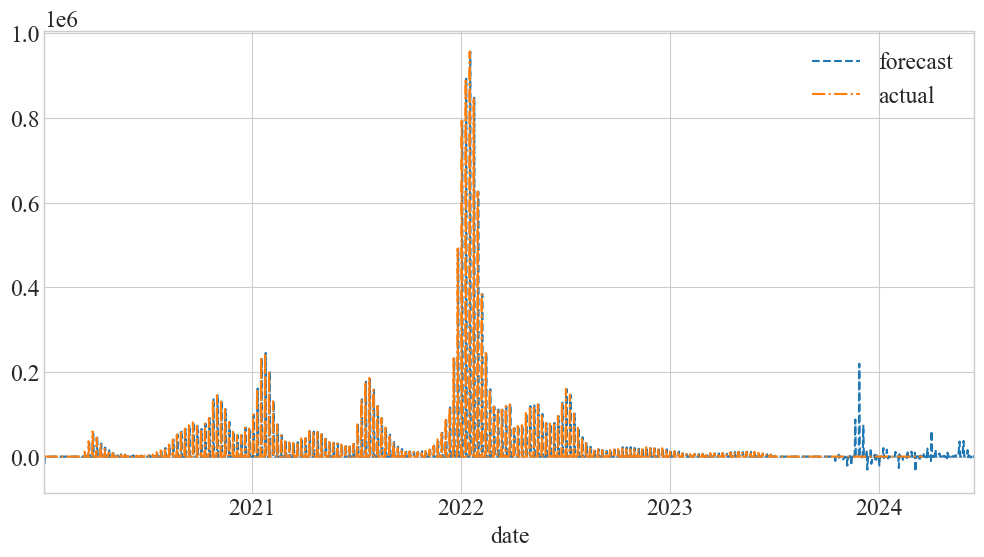

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
forecasted.set_index("date").plot(linestyle='--', ax=ax)
actual.set_index("date").plot(linestyle='-.', ax=ax)
plt.legend(["forecast", "actual"])

In [18]:
test_data = actual.merge(forecasted, on="date", suffixes=("_actual", "_predicted"))

mse = mean_squared_error(test_data.new_cases_actual, test_data.new_cases_predicted, squared=False)  # RMSE
print("The root mean squared error (RMSE) on test set: {:.2f}".format(mse))

The root mean squared error (RMSE) on test set: 79537.66


C:\Users\TROPIBIO\mambaforge\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
